In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
from AttentionModule import Conv2d_Attn

import torch
from torch import nn
from torchvision import models, datasets, transforms
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import re
import numpy as np

In [3]:
resnet_pretrained = models.resnet50(pretrained=True)
nn.Conv2d = Conv2d_Attn
resnet_attn = models.resnet50()
resnet_attn.load_state_dict(resnet_pretrained.state_dict(), strict=False)

In [4]:
# This block turns 'layer1.0.downsample.0.weight' to 'layer1[0].downsample[0].weight'
param_keys = list(resnet_attn.state_dict().keys())
formatted_keys = []
for k in param_keys:
    found = re.findall(r'\.[\d]{1,2}\.', k)
    if len(found):
        for f in found:
            k = k.replace(f, '[{}].'.format(f.strip('.')))
    formatted_keys.append(k)

In [5]:
# This block turn off gradient up for all params except attn_weights
def turn_off_grad_except(lst=[]):
    for k in formatted_keys:
        obj = eval('resnet_attn.'+k)
        for kw in lst:
            if not kw in k:
                obj.requires_grad = False
            else:
                obj.requires_grad = True

In [6]:
resnet_attn.fc = nn.Linear(resnet_attn.fc.in_features, 144)

Start training

In [7]:
batch_size = 32

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
    [transforms.ToTensor(),
     normalize])

trainset = torchvision.datasets.ImageFolder(root='../data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [9]:
total_imgs = len(trainset.imgs)

In [10]:
resnet_attn = resnet_attn.cuda()

In [11]:
total_attn_params = 0
for k in formatted_keys:
    obj = eval('resnet_attn.'+k)
    if 'attn_weights' in k:
        total_attn_params += np.prod(obj.shape)
print("Total number of attention parameters", total_attn_params)

Total number of attention parameters 26560


We want the attention parameters to diverge from 1, therefore we penalize element-wise square loss as $\lambda (1 \times \text{# params} - (x - 1)^2)$

But this is too big a number,
let's try: 
$- (x - 1)^2$ for now

In [12]:
_lambda = 1e-2 #set default

In [13]:
def get_params_objs(name, net='resnet_attn'):
    res = []
    for k in formatted_keys:
        obj = eval(f'{net}.'+k)
        if name in k:
            res.append(obj)
    return res

In [14]:
def compute_attn_loss(n_params=26560):
    attns = get_params_objs('attn_weights')
    penality = sum([torch.pow(t - 1,2).mean() for t in attns])
    return _lambda*(- penality)

In [15]:
print_every = 5

In [16]:
def score_top3():
    correct_count = 0
    for inp, label in tqdm(iter(valloader)):
        _, idx = resnet_attn(Variable(inp).cuda()).topk(3)
        lab = Variable(label).cuda()
        lab_expand = lab.unsqueeze(1).expand_as(idx)
        correct_count += int((idx == lab_expand).sum())
    print(correct_count/len(valset))

In [23]:
def train(k=1, add_attn=True, score='val', plot_hist=False):
    cls_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet_attn.parameters()))
    
    for j in range(k):
        running_loss = 0.0
        running_attn_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()

            optimizer.zero_grad()
            outputs = resnet_attn(inputs)
            loss = cls_criterion(outputs, labels)
            attn_loss = compute_attn_loss()
            if add_attn:
                loss += attn_loss

            loss.backward()
            optimizer.step()


            running_loss += loss.data[0]
            running_attn_loss += attn_loss.data[0]

            if i % print_every == 0:
                print('[%5d] iter, [%2f] epoch, avg loss: %.3f, attn_loss: %.5f ' %
                      (i + 1, i*batch_size/total_imgs, running_loss/print_every, running_attn_loss/print_every))
                running_loss = 0.0
                running_attn_loss = 0.0
        if score == 'val':
            score_top3()
        if plot_hist:
            plot_attn_hist()

In [24]:
print_every=50

In [25]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [26]:
valset = torchvision.datasets.ImageFolder(root='../data/val', transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [27]:
def plot_attn_hist():
    attns = get_params_objs('attn_weights')
    attns = torch.cat([attn.squeeze() for attn in attns])
    attns_arr = attns.data.cpu().numpy()
    plt.hist(attns_arr)

[    1] iter, [0.000000] epoch, avg loss: 0.100, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, avg loss: 4.266, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, avg loss: 3.487, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, avg loss: 3.229, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, avg loss: 3.028, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, avg loss: 2.957, attn_loss: 0.00000 


100%|██████████| 55/55 [00:13<00:00,  3.97it/s]

0.5188141391106044


[    1] iter, [0.000000] epoch, avg loss: 0.045, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, avg loss: 2.510, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, avg loss: 2.467, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, avg loss: 2.408, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, avg loss: 2.403, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, avg loss: 2.409, attn_loss: 0.00000 


100%|██████████| 55/55 [00:13<00:00,  3.94it/s]

0.5592930444697833


[    1] iter, [0.000000] epoch, avg loss: 0.040, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, avg loss: 2.063, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, avg loss: 2.021, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, avg loss: 1.979, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, avg loss: 2.140, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, avg loss: 2.171, attn_loss: 0.00000 


100%|██████████| 55/55 [00:13<00:00,  3.93it/s]

0.556442417331813


[    1] iter, [0.000000] epoch, avg loss: 0.032, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, avg loss: 1.838, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, avg loss: 1.804, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, avg loss: 1.804, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, avg loss: 1.841, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, avg loss: 1.880, attn_loss: 0.00000 


100%|██████████| 55/55 [00:13<00:00,  3.93it/s]

0.5689851767388826


[    1] iter, [0.000000] epoch, avg loss: 0.034, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, avg loss: 1.664, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, avg loss: 1.608, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, avg loss: 1.689, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, avg loss: 1.603, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, avg loss: 1.698, attn_loss: 0.00000 


100%|██████████| 55/55 [00:14<00:00,  3.92it/s]

0.5786773090079818


[    1] iter, [0.000000] epoch, avg loss: 0.028, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, avg loss: 1.473, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, avg loss: 1.437, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, avg loss: 1.530, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, avg loss: 1.560, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, avg loss: 1.600, attn_loss: 0.00000 


100%|██████████| 55/55 [00:13<00:00,  3.93it/s]

0.5746864310148233


[    1] iter, [0.000000] epoch, avg loss: 0.029, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, avg loss: 1.296, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, avg loss: 1.440, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, avg loss: 1.376, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, avg loss: 1.457, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, avg loss: 1.484, attn_loss: 0.00000 


100%|██████████| 55/55 [00:13<00:00,  3.93it/s]

0.5826681870011402


[    1] iter, [0.000000] epoch, avg loss: 0.030, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, avg loss: 1.205, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, avg loss: 1.238, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, avg loss: 1.336, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, avg loss: 1.358, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, avg loss: 1.338, attn_loss: 0.00000 


100%|██████████| 55/55 [00:13<00:00,  3.93it/s]

0.5792474344355758


[    1] iter, [0.000000] epoch, avg loss: 0.021, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, avg loss: 1.206, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, avg loss: 1.186, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, avg loss: 1.157, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, avg loss: 1.258, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, avg loss: 1.308, attn_loss: 0.00000 


100%|██████████| 55/55 [00:13<00:00,  3.93it/s]

0.5917901938426454


[    1] iter, [0.000000] epoch, avg loss: 0.019, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, avg loss: 1.144, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, avg loss: 1.118, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, avg loss: 1.136, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, avg loss: 1.175, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, avg loss: 1.194, attn_loss: 0.00000 


100%|██████████| 55/55 [00:14<00:00,  3.93it/s]

0.5866590649942988


[    1] iter, [0.000000] epoch, avg loss: 0.026, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, avg loss: 0.997, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, avg loss: 1.092, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, avg loss: 1.086, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, avg loss: 1.083, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, avg loss: 1.178, attn_loss: 0.00000 


100%|██████████| 55/55 [00:14<00:00,  3.93it/s]

0.5997719498289624


[    1] iter, [0.000000] epoch, avg loss: 0.020, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, avg loss: 0.981, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, avg loss: 0.993, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, avg loss: 1.044, attn_loss: 0.00000 


Process Process-46:
Process Process-45:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/miniconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/ubuntu/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/miniconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/ubuntu/miniconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index

KeyboardInterrupt: 

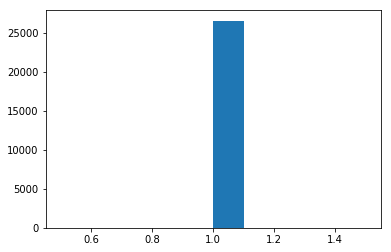

In [28]:
turn_off_grad_except(['fc'])
resnet_attn.eval() # Turn on batchnorm
train(20, add_attn=False, plot_hist=True)